In [1]:
from ipywidgets import *
from ipywidgets.widgets import IntSlider, FloatSlider
import numpy as np
from math import *
import matplotlib.pyplot as plt
from scipy.optimize import root
from scipy.interpolate import interp1d

%matplotlib widget

interactive(children=(FloatSlider(value=28.956, description='L1', min=10.0, step=1.0), FloatSlider(value=49.27…

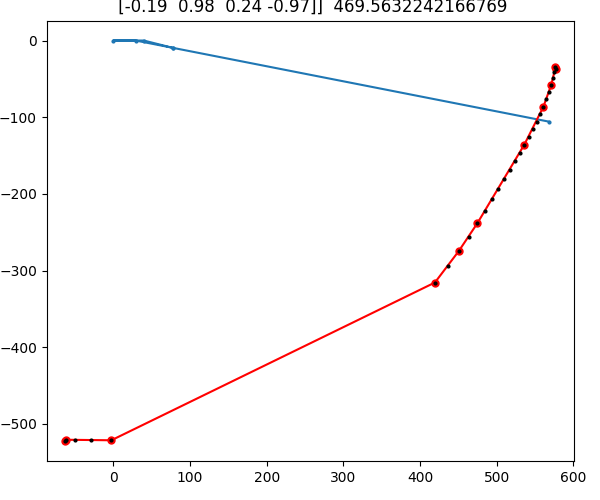

In [16]:
def get_endpt(dims, theta1, guess):
    L1, L2, L3, L4, L5, theta5 = dims
    sin5 = sin(theta5)
    cos5 = cos(theta5)

    sin1 = sin(theta1)
    cos1 = cos(theta1) 
    def func_sincos(vars):
        sin2, cos2, sin3, cos3 = vars
        return [
            L1*sin1 + L2*sin2 + L3*sin3,
            L1*cos1 + L2*cos2 + L3*cos3 - L4, 
            sin2**2 + cos2**2 - 1,
            sin3**2 + cos3**2 - 1,        
        ]
    def jac_sincos(vars):
        sin2, cos2, sin3, cos3 = vars
        return [
            [L2, 0, L3, 0],
            [0, L2, 0, L3],
            [2*sin2, 2*cos2, 0, 0],
            [0, 0, 2*sin3, 2*cos3]
        ]
    
    sol = root(func_sincos, jac=jac_sincos, x0=guess, method='hybr').x
    sin2, cos2, sin3, cos3 = sol
    guess = sol

    p5 = L1*np.array([cos1, sin1]) + L2*np.array([cos2, sin2]) + L5*np.array([cos2*cos5-sin2*sin5, sin2*cos5+cos2*sin5])
    return p5, sol

def get_path(dims, npts, guess, TR_cutoff=10):
    theta1_range = np.linspace(0, 2*pi, npts)
    path = []
    sols = []

    last_p5 = np.zeros(2)
    for theta1 in theta1_range:
        p5, sol = get_endpt(dims, theta1, guess)
        guess = sol
        if(np.linalg.norm(p5 - last_p5) < TR_cutoff):
            path.append(p5)
        sols.append(sol)
        last_p5 = p5

    return np.array(path), sols

def get_links(dims, sols, theta1_vis=0):
    L1, L2, L3, L4, L5, theta5 = dims
    sin1, cos1 = (sin(2*pi*theta1_vis/npts), cos(2*pi*theta1_vis/npts))
    sin5, cos5 = (sin(theta5), cos(theta5))

    # path, sol = get_endpt(dims, theta1_vis, guess)
    sin2, cos2, sin3, cos3 = sols[theta1_vis]

    p0 = np.array([0, 0])
    p1 = p0 + L1*np.array([cos1, sin1])
    p2 = p1 + L2*np.array([cos2, sin2])
    p3 = p2 + L3*np.array([cos3, sin3])
    p4 = np.array([0, 0])
    p5 = L1*np.array([cos1, sin1]) + L2*np.array([cos2, sin2]) + L5*np.array([cos2*cos5-sin2*sin5, sin2*cos5+cos2*sin5])

    return np.array([p5, p2, p3, p4, p1, p2])

def douglas_peucker(points, epsilon):
    if len(points) <= 2:
        return points
    
    dmax = 0
    index = 0
    
    for i in range(1, len(points) - 1):
        d = perpendicular_distance(points[i], points[0], points[-1])
        if d > dmax:
            index = i
            dmax = d
    
    if dmax > epsilon:
        recursive_result1 = douglas_peucker(points[:index + 1], epsilon)
        recursive_result2 = douglas_peucker(points[index:], epsilon)
        return np.concatenate((recursive_result1[:-1], recursive_result2))
    else:
        return np.array([points[0], points[-1]])

def perpendicular_distance(p, p1, p2):
    # Calculate the perpendicular distance of point p from line formed by p1 and p2
    return np.abs(np.cross(p2 - p1, p - p1)) / np.linalg.norm(p2 - p1)

def longest_segment_length(points):
    max_length = 0
    for i in range(len(points) - 1):
        segment_length = np.linalg.norm(points[i] - points[i + 1])
        max_length = max(max_length, segment_length)
    return max_length


dims = (1, 2.5, 2.5, 2, 2.5, radians(10))
npts = 50

guess = np.array([-0.37, 0.93, 0.47, -0.88]) #almost 400mm test stand 

path, sols = get_path(dims, npts, guess)
links = get_links(dims, sols)

path_simp = douglas_peucker(path, 0.1)



plt.close()
fig = plt.figure(figsize=(6,5))
ax = fig.subplots(1, 1)
fig.tight_layout()
ax.axis('equal')
# ax.set_xlim(-4, 9)
# ax.set_ylim(-10, 3)

link_pts, = ax.plot(links[:,0], links[:,1], 'o-', markersize=2)
simp_pts, = ax.plot(path_simp[:,0], path_simp[:,1], 'ro-', markersize=5)
path_pts, = ax.plot(path[:,0], path[:,1], 'ko', markersize=2)

def update(
        L1=FloatSlider(min=10, max=100, step=1, value=28.956),
        L2=FloatSlider(min=10, max=100, step=1, value=49.276),
        L3=FloatSlider(min=10, max=100, step=1, value=38.862),
        L4=FloatSlider(min=10, max=100, step=1, value=39.624),
        L5=FloatSlider(min=10, max=500, step=1, value=500),
        theta5=FloatSlider(min=-90, max=90, step=1, value=0),
        theta1_vis=IntSlider(min=0, max=npts-1, step=1, value=0),
        epsilon=FloatSlider(min=0, max=5, step=0.1, value=1),
        TR_cutoff=FloatSlider(min=0, max=50, step=0.1, value=30)
        ):
    dims = (L1, L2, L3, L4, L5, radians(theta5))

    # global guess
    path, sols = get_path(dims, npts, guess, TR_cutoff)

    if len(path) < 2:
        return
    # guess = sols[0]

    links = get_links(dims, sols, theta1_vis)
    path_simp = douglas_peucker(path, epsilon)

    ax.set_title(f"{np.round(sols, 2)}  {longest_segment_length(path_simp)}")
    
    path_pts.set_data((path[:,0], path[:,1]))
    link_pts.set_data((links[:,0], links[:,1]))
    simp_pts.set_data((path_simp[:,0], path_simp[:,1]))

    fig.canvas.draw_idle()
    ax.relim()
    ax.autoscale_view(True,True,True)

    

_ = interact(update)

interactive(children=(FloatSlider(value=28.956, description='L1', min=10.0, step=1.0), FloatSlider(value=49.27…

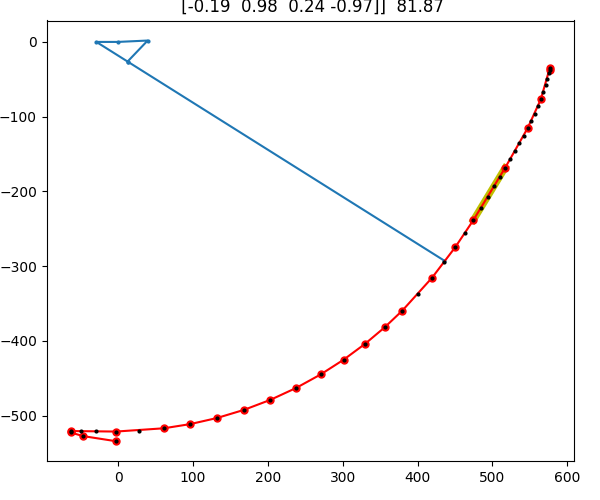

In [45]:
def get_endpt(dims, theta1, guess):
    L1, L2, L3, L4, L5, theta5 = dims
    sin5 = sin(theta5)
    cos5 = cos(theta5)

    sin1 = sin(theta1)
    cos1 = cos(theta1) 
    def func_sincos(vars):
        sin2, cos2, sin3, cos3 = vars
        return [
            L1*sin1 + L2*sin2 + L3*sin3,
            L1*cos1 + L2*cos2 + L3*cos3 - L4, 
            sin2**2 + cos2**2 - 1,
            sin3**2 + cos3**2 - 1,        
        ]
    def jac_sincos(vars):
        sin2, cos2, sin3, cos3 = vars
        return [
            [L2, 0, L3, 0],
            [0, L2, 0, L3],
            [2*sin2, 2*cos2, 0, 0],
            [0, 0, 2*sin3, 2*cos3]
        ]
    
    sol = root(func_sincos, jac=jac_sincos, x0=guess, method='hybr').x
    sin2, cos2, sin3, cos3 = sol
    guess = sol

    p5 = L1*np.array([cos1, sin1]) + L2*np.array([cos2, sin2]) + L5*np.array([cos2*cos5-sin2*sin5, sin2*cos5+cos2*sin5])
    return p5, sol

def get_path(dims, npts, guess, TR_cutoff=10):
    theta1_range = np.linspace(0, 2*pi, npts)
    path = []
    sols = []

    for theta1 in theta1_range:
        p5, sol = get_endpt(dims, theta1, guess)
        guess = sol
        path.append(p5)
        sols.append(sol)


    start_i = int(npts/2)
    end_i = int(npts/2)

    last_p5 = path[start_i]
    while start_i > 0:
        p5 = path[start_i]
        if np.linalg.norm(p5 - last_p5) > TR_cutoff:
            break
        last_p5 = p5
        start_i -= 1

    last_p5 = path[end_i]
    while end_i < npts:
        p5 = path[end_i]
        if np.linalg.norm(p5 - last_p5) > TR_cutoff:
            break
        last_p5 = p5
        end_i += 1

    return np.array(path[start_i:end_i]), sols

def get_links(dims, sols, theta1_vis=0):
    L1, L2, L3, L4, L5, theta5 = dims
    sin1, cos1 = (sin(2*pi*theta1_vis/npts), cos(2*pi*theta1_vis/npts))
    sin5, cos5 = (sin(theta5), cos(theta5))

    # path, sol = get_endpt(dims, theta1_vis, guess)
    sin2, cos2, sin3, cos3 = sols[theta1_vis]

    p0 = np.array([0, 0])
    p1 = p0 + L1*np.array([cos1, sin1])
    p2 = p1 + L2*np.array([cos2, sin2])
    p3 = p2 + L3*np.array([cos3, sin3])
    p4 = np.array([0, 0])
    p5 = L1*np.array([cos1, sin1]) + L2*np.array([cos2, sin2]) + L5*np.array([cos2*cos5-sin2*sin5, sin2*cos5+cos2*sin5])

    return np.array([p5, p2, p3, p4, p1, p2])

def douglas_peucker(points, epsilon):
    if len(points) <= 2:
        return points
    
    dmax = 0
    index = 0
    
    for i in range(1, len(points) - 1):
        d = perpendicular_distance(points[i], points[0], points[-1])
        if d > dmax:
            index = i
            dmax = d
    
    if dmax > epsilon:
        recursive_result1 = douglas_peucker(points[:index + 1], epsilon)
        recursive_result2 = douglas_peucker(points[index:], epsilon)
        return np.concatenate((recursive_result1[:-1], recursive_result2))
    else:
        return np.array([points[0], points[-1]])

def perpendicular_distance(p, p1, p2):
    # Calculate the perpendicular distance of point p from line formed by p1 and p2
    return np.abs(np.cross(p2 - p1, p - p1)) / np.linalg.norm(p2 - p1)

def longest_segment_length(points):
    max_length = 0
    max_indexes = (0, 0)
    for i in range(len(points) - 1):
        segment_length = np.linalg.norm(points[i] - points[i + 1])
        if segment_length > max_length:
            max_length = segment_length
            max_indexes = (i, i+1)
    return max_length, max_indexes


dims_0 = (28.956, 49.276, 38.862, 39.624, 500, 0)
npts = 50

guess = np.array([-0.37, 0.93, 0.47, -0.88]) #almost 400mm test stand 

path, sols = get_path(dims_0, npts, guess)
links = get_links(dims_0, sols)

path_simp = douglas_peucker(path, 0.1)



plt.close()
fig = plt.figure(figsize=(6,5))
ax = fig.subplots(1, 1)
fig.tight_layout()
ax.axis('equal')
# ax.set_xlim(-4, 9)
# ax.set_ylim(-10, 3)

max_pts, = ax.plot([0,1], [0,1], 'y-', linewidth=5)
link_pts, = ax.plot(links[:,0], links[:,1], 'o-', markersize=2)
simp_pts, = ax.plot(path_simp[:,0], path_simp[:,1], 'ro-', markersize=5)
path_pts, = ax.plot(path[:,0], path[:,1], 'ko', markersize=2)

def update(
    L1=FloatSlider(min=10, max=100, step=1, value=dims_0[0]),
    L2=FloatSlider(min=10, max=100, step=1, value=dims_0[1]),
    L3=FloatSlider(min=10, max=100, step=1, value=dims_0[2]),
    L4=FloatSlider(min=10, max=100, step=1, value=dims_0[3]),
    # L5=FloatSlider(min=10, max=500, step=1, value=dims_0[4]),
    theta5=FloatSlider(min=-90, max=90, step=1, value=dims_0[5]),
    theta1_vis=IntSlider(min=0, max=npts-1, step=1, value=npts/2),
    epsilon=FloatSlider(min=0, max=5, step=0.1, value=1),
    TR_cutoff=FloatSlider(min=0, max=100, step=0.1, value=42)
    ):
    dims = (L1, L2, L3, L4, dims_0[4], radians(theta5))

    path, sols = get_path(dims, npts, guess, TR_cutoff)
    if len(path) < 2:
        return

    links = get_links(dims, sols, theta1_vis)
    path_simp = douglas_peucker(path, epsilon)

    max_length, max_indexes = longest_segment_length(path_simp)
    ax.set_title(f"{np.round(sols, 2)}  {round(max_length,2)}")
    
    path_pts.set_data((path[:,0], path[:,1]))
    link_pts.set_data((links[:,0], links[:,1]))
    simp_pts.set_data((path_simp[:,0], path_simp[:,1]))
    max_pts.set_data((path_simp[max_indexes[0]:max_indexes[1]+1,0], path_simp[max_indexes[0]:max_indexes[1]+1,1]))

    fig.canvas.draw_idle()
    ax.relim()
    ax.autoscale_view(True,True,True)

    

_ = interact(update)

linkage for test stand: want something with low inertia, moves in a straight enough line, long stroke, 
links are at least 1" long, only one long link.